# Proyecto de Bot de Trading de Bitcoin
**Objetivo del Proyecto**

Este proyecto tiene como objetivo crear un bot de trading automatizado que analice el comportamiento del precio de Bitcoin en tiempo real y tome decisiones de compra, venta o mantener, basándose en medias móviles simples y tendencias de mercado.

Enero 2025

# **1. Configuración del Ambiente**


In [26]:
## *1
#1.1- Importar librerías de manipulación de datos
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas del DataFrame
pd.set_option('display.expand_frame_repr', False)  # Evitar que el DataFrame se divida en varias líneas si tiene muchas columnas

# Importar librerías para manejo de tiempo y fecha
import time
from datetime import datetime, timedelta, timezone

# Importar librerías de scraping
import requests
from bs4 import BeautifulSoup

# Importar librerías de visualización
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (5, 5))  # Establecer el tamaño predeterminado de las figuras a 5x5 pulgadas

# Importar librerías específicas de entorno Jupyter
from IPython.display import clear_output

# Importar librería para obtención de datos financieros
import yfinance as yf

# Variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color


In [17]:
## *2
#1.2 Muestra versiones de las bibliotecas
# Verificar la versión de Python
!python --version

# Verificar la versión de pandas
!pip show pandas | grep Version

# Verificar la versión de numpy
!pip show numpy | grep Version

# Verificar la versión de matplotlib
!pip show matplotlib | grep Version



Python 3.11.11
Version: 2.2.2
Version: 1.26.4
Version 3.1, 31 March 2009
                       Version 3, 29 June 2007
  5. Conveying Modified Source Versions.
  14. Revised Versions of this License.
Version: 3.10.0


# **2. Obtención de datos**

### 2.1 Precios Históricos del Bitcoin

In [36]:
## *3
def importar_base_bitcoin():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

    end_date = datetime.now()
    start_date = end_date - timedelta(days=14)

    # Obtener los datos históricos de Bitcoin usando yfinance
    df_bitcoin = yf.download(
        tickers="BTC-USD",
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval="15m"
    )

    # Verificar que los datos se hayan descargado correctamente
    if df_bitcoin.empty:
      raise ValueError("No se pudieron obtener los datos de Bitcoin.")

    #Aplanar el MultiIndex de las columnas
    df_bitcoin.columns = [col[0] for col in df_bitcoin.columns.values]

    return df_bitcoin

In [37]:
# *4
importar_base_bitcoin()
df_bitcoin.head(10)

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-01-18 00:00:00,104352.453125,104382.625000,104114.414062,104114.414062,109543424
2025-01-18 00:15:00,104256.257812,104455.789062,104245.593750,104369.625000,0
2025-01-18 00:30:00,104563.835938,104563.835938,104237.109375,104237.585938,33390592
2025-01-18 00:45:00,104600.203125,104622.781250,104569.304688,104573.664062,40837120
2025-01-18 01:00:00,104496.882812,104628.773438,104463.281250,104628.773438,0
2025-01-18 01:15:00,104612.515625,104612.515625,104347.515625,104418.750000,23027712
2025-01-18 01:30:00,104367.101562,104595.578125,104367.101562,104595.578125,67616768
2025-01-18 01:45:00,104273.695312,104280.140625,104152.429688,104280.140625,0
2025-01-18 02:00:00,104398.671875,104422.992188,104288.562500,104288.562500,0


[*********************100%***********************]  1 of 1 completed


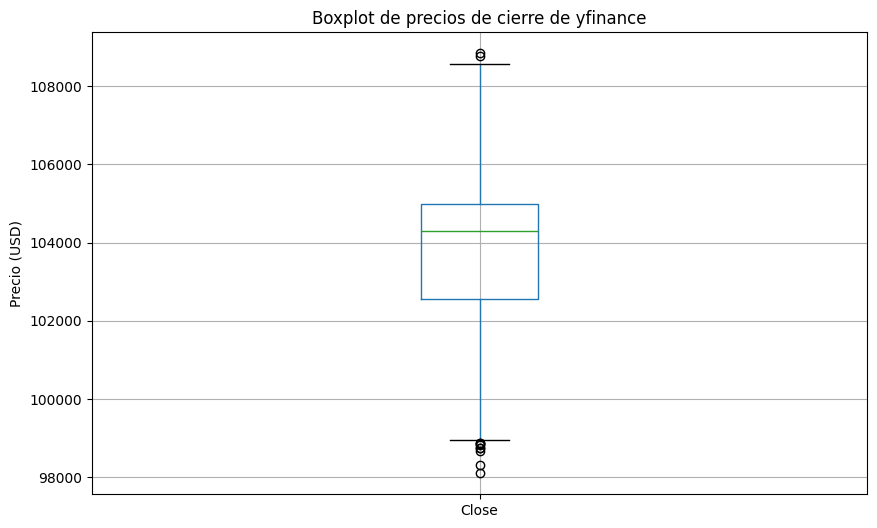

In [38]:
importar_base_bitcoin()

plt.figure(figsize=(10, 6))
df_bitcoin.boxplot(column=['Close'])
plt.title('Boxplot de precios de cierre de yfinance')
plt.ylabel('Precio (USD)')
plt.show()

In [39]:
## *5

def extraer_tendencias():
    global precio_actual, tendencia, color
    global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color


    # Headers para evitar ser bloqueado
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0'}
    url = "https://coinmarketcap.com/currencies/bitcoin/"

    try:
        # Realizar la solicitud y parsear el contenido
        respuesta = requests.get(url, headers=headers)
        respuesta.raise_for_status()
        soup = BeautifulSoup(respuesta.content, 'html.parser')

        # Extraer el precio actual de Bitcoin
        precio_tag = soup.find('span', {'data-test': 'text-cdp-price-display'})
        if precio_tag:
            precio_actual = float(precio_tag.text.replace('$', '').replace(',', ''))
        else:
            precio_actual = None

        # Extraer la tendencia del precio
        tendencia_tag = soup.find('p', {'color': True, 'data-change': True})
        if tendencia_tag:
            color = tendencia_tag['color']
            if color == 'green':
                tendencia = 'alcista'
            elif color == 'red':
                tendencia = 'bajista'
            else:
                tendencia = None
        else:
            tendencia = None

        #Retornar el precio actual
        return precio_actual, tendencia, color

    except requests.exceptions.RequestException as e:
        print(f'Error al hacer la solicitud: {e}')
        return None, None, None

# Llamar a la función y mostrar los resultados
resultados = extraer_tendencias()
if resultados[0] is not None:
    print(f'Precio actual: ${resultados[0]:,.2f}')
    print(f'Tendencia: {resultados[1]}')
else:
    print("No se pudieron obtener los datos.")

Precio actual: $102,621.84
Tendencia: bajista


### 2.2 Indicadores de Tendencias

**ATENCION**
Los selectores HTML pueden variar según las actualizaciones del sitio web, así que si el scraping no funciona
revisen la estructura actualizada del HTML.

# **3. Limpieza de datos**

## 3.1 Exploración inicial de los datos de Bitcoin sin tratamiento

In [40]:
# *6 original
#Muestra informaciones de la base original, sin tratamiento
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1344 entries, 2025-01-18 00:00:00 to 2025-01-31 23:45:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1344 non-null   float64
 1   High    1344 non-null   float64
 2   Low     1344 non-null   float64
 3   Open    1344 non-null   float64
 4   Volume  1344 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 63.0 KB
None


,Close,High,Low,Open,Volume
count,1344.0,1344.0,1344.0,1344.0,1.344000e+03
mean,103841.0,104005.0,103672.0,103838.0,2.265300e+08
std,1736.0,1723.0,1749.0,1737.0,5.315415e+08
min,98105.0,98818.0,97907.0,97907.0,0.000000e+00
25%,102570.0,102733.0,102435.0,102580.0,0.000000e+00
50%,104295.0,104422.0,104183.0,104294.0,1.961370e+07
75%,104991.0,105078.0,104896.0,104990.0,2.230907e+08
max,108838.0,109110.0,108120.0,108900.0,6.540714e+09


In [25]:
# *7
#cantidad de valores ceros en la columna volume
(df_bitcoin['Volume'] == 0).sum()

203

## 3.2 Visualización de la distribución del Precio de Cierre sin tratamiento

<Axes: >

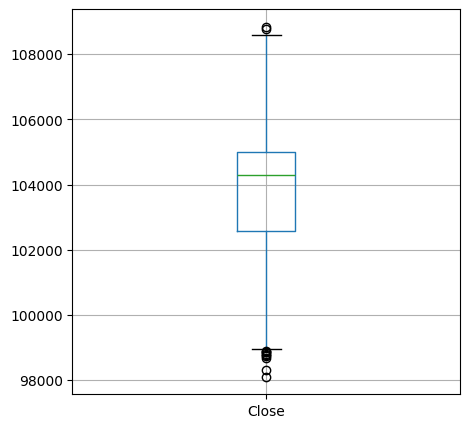

In [41]:
# *8 original
#Muestra el boxplot de la base sin tratamiento
df_bitcoin.boxplot(['Close'])

## 3.3 Función para la limpieza de los datos de Bitcoin

Dentro de ella, Se definen nuevamente las variables globales

Antes de limpiar la base, se crea una copia de la base df_bitcoin para  realizar la limpieza en esta nueva base(df_bitcoin_limpio), sin modificar la base original:

In [42]:
#*9
def limpieza_datos():
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin, precio_actual, tendencia

    # Crear una copia del DataFrame original
    df_bitcoin_limpio = df_bitcoin.copy()

    # 1. Eliminar índices duplicados
    df_bitcoin_limpio = df_bitcoin_limpio.loc[~df_bitcoin_limpio.index.duplicated(keep='first')]

    # 2. Tratar valores nulos en la columna Close, rellenar con el último valor válido
    df_bitcoin_limpio['Close'] = df_bitcoin_limpio['Close'].ffill()

    # 3. Eliminar filas con Volumen menor o igual a 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]


    # 4. Identificar y eliminar outliers
    Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    Q3 = df_bitcoin_limpio['Close'].quantile(0.75)
    IQR = Q3 - Q1
    df_bitcoin_limpio = df_bitcoin_limpio[
        (df_bitcoin_limpio['Close'] >= Q1 - 1.5 * IQR) &
         (df_bitcoin_limpio['Close'] <= Q3 + 1.5 * IQR)]


    # Calcular el precio promedio del BTC
    media_bitcoin = df_bitcoin_limpio['Close'].mean()


    return df_bitcoin_limpio, media_bitcoin

## 3.4 Visualización de la distribución del Precio de Cierre después de la limpieza

In [43]:
#*10
# Visualizar las estadisticas del df limpio
limpieza_datos()
df_bitcoin_limpio.describe()

,Close,High,Low,Open,Volume
count,765.000000,765.000000,765.000000,765.000000,7.650000e+02
mean,103588.546181,103779.268566,103369.841279,103565.952655,3.959760e+08
std,1960.311831,1953.396522,1956.901831,1956.524291,6.533341e+08
min,98325.734375,98818.117188,97906.976562,97906.976562,1.638400e+04
25%,102235.750000,102391.828125,102052.507812,102233.976562,5.354701e+07
50%,104029.335938,104224.765625,103715.781250,104024.976562,1.658470e+08
75%,104937.257812,105039.929688,104765.828125,104924.460938,4.876268e+08
max,108837.968750,109110.390625,108120.093750,108899.929688,6.540714e+09


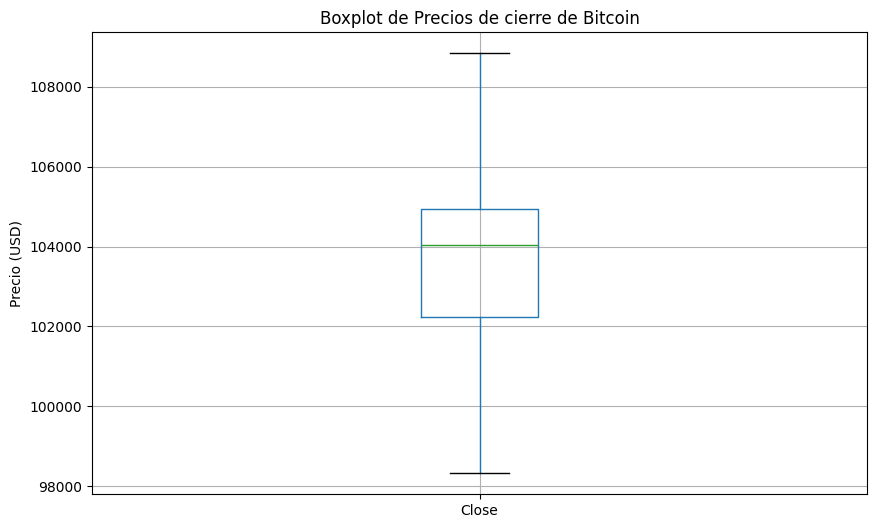

In [44]:
# *11
#limpieza_datos()
#Muestra el Boxplot de la base limpia
plt.figure(figsize=(10, 6))
df_bitcoin_limpio.boxplot(['Close'])
plt.title('Boxplot de Precios de cierre de Bitcoin')
plt.ylabel('Precio (USD)')
plt.show()

#df_bitcoin_limpio.boxplot(['Close'])

## 3.5 Comparación de la distribución del Precio de Cierre antes y después de la limpieza

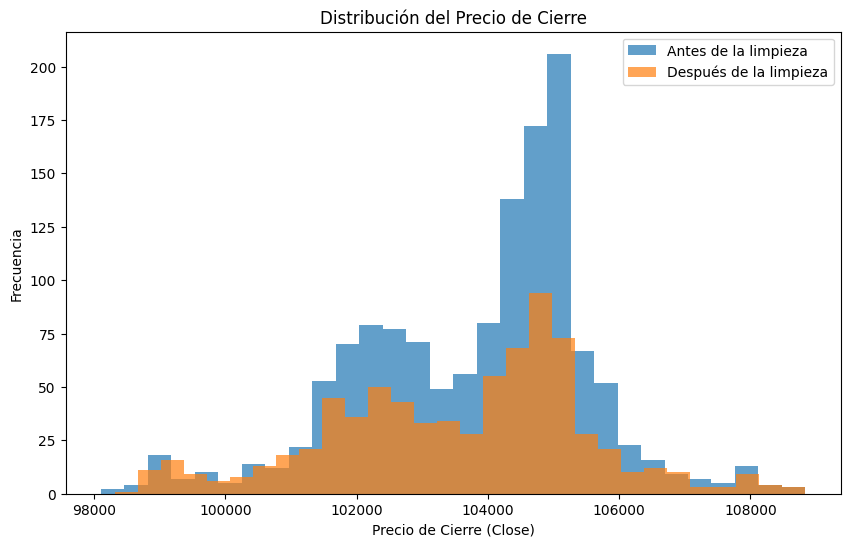

In [45]:
#*11
#@title Gráfico de distribución del Precio de Cierre antes y después de la limpieza { display-mode: "form" }
# Gráfico de antes y después de la limpieza de la distribución del Precio de Cierre
plt.figure(figsize=(10, 6))
plt.hist(df_bitcoin['Close'], bins=30, alpha=0.7, label='Antes de la limpieza')
plt.hist(df_bitcoin_limpio['Close'], bins=30, alpha=0.7, label='Después de la limpieza')
plt.legend()
plt.title('Distribución del Precio de Cierre')
plt.xlabel('Precio de Cierre (Close)')
plt.ylabel('Frecuencia')
plt.show()

# 4. Tomar decisiones

## 4.1 Encontrar medias moviles

In [46]:
#12
def calcular_sma():
    global df_bitcoin_limpio

    # Calcular la SMA de corto plazo (por ejemplo, 10 periodos)
    df_bitcoin_limpio['SMA_corto'] = df_bitcoin_limpio['Close'].rolling(window=10).mean()

    # Calcular la SMA de largo plazo (por ejemplo, 50 periodos)
    df_bitcoin_limpio['SMA_largo'] = df_bitcoin_limpio['Close'].rolling(window=50).mean()

calcular_sma()

## 4.2 Evaluar datos y tomar decision

In [47]:
#no
def tomar_decisiones():
    global df_bitcoin_limpio, tendencia, media_bitcoin, precio_actual

    # Calcular la media móvil de 20 periodos
    # media_bitcoin = df_bitcoin_limpio['Close'].rolling(window=20).mean()

    # Obtener el precio actual (último valor en el dataframe limpio)
    precio_actual = df_bitcoin_limpio['Close'].iloc[-1]

    # Determinar la tendencia
    if precio_actual > media_bitcoin.iloc[-1]:
        tendencia = "alcista"  # Precio por encima de la media = tendencia alcista
    else:
        tendencia = "bajista"  # Precio por debajo de la media = tendencia bajista

    # Calcular las SMAs
    sma_corto_actual = df_bitcoin_limpio['SMA_corto'].iloc[-1]
    sma_largo_actual = df_bitcoin_limpio['SMA_largo'].iloc[-1]

    # Lógica de decisión (Comprar, Vender o Mantener)
    if sma_corto_actual > sma_largo_actual and tendencia == 'alcista':
        algoritmo_decision = 'Comprar'
        color = "🟢"  # Verde para comprar
    elif sma_corto_actual < sma_largo_actual and tendencia == 'bajista':
        algoritmo_decision = 'Vender'
        color = color = "🔴"  # Rojo para vender
    else:
        algoritmo_decision = 'Mantener'
        color = "⚫"  # Negro| para neutral

    # Guardar la decisión en el dataframe
    df_bitcoin_limpio.loc[df_bitcoin_limpio.index[-1], 'Decision'] = algoritmo_decision

    # Imprimir la decisión
    print(f"Decisión: {algoritmo_decision} | SMA corto: {sma_corto_actual} | SMA largo: {sma_largo_actual}")
    print(f"Tendencia: {tendencia} | Precio actual: {precio_actual} | Color: {color}")

    return df_bitcoin_limpio, algoritmo_decision, color

In [49]:
#13
def tomar_decisiones():
    global df_bitcoin_limpio, algoritmo_decision, color

    # Crear una columna para almacenar las decisiones
    df_bitcoin_limpio['Decision'] = 'Mantenerse'

    # Cuando la SMA_corto cruza hacia arriba a la SMA_Largo -> Comprar
    df_bitcoin_limpio.loc[
        (df_bitcoin_limpio['SMA_corto'] > df_bitcoin_limpio['SMA_largo']) &
        (df_bitcoin_limpio['SMA_corto'].shift(1) <= df_bitcoin_limpio['SMA_largo'].shift(1)),
        'Decision'
    ] = 'Comprar'

    # Cuando la SMA_corto cruza hacia abajo a la SMA_Largo -> Vender
    df_bitcoin_limpio.loc[
        (df_bitcoin_limpio['SMA_corto'] < df_bitcoin_limpio['SMA_largo']) &
        (df_bitcoin_limpio['SMA_corto'].shift(1) >= df_bitcoin_limpio['SMA_largo'].shift(1)),
        'Decision'
    ] = 'Vender'

    # Determinar la última decisión
    algoritmo_decision = df_bitcoin_limpio['Decision'].iloc[0]

    # Asignar color según la decisión
    if algoritmo_decision == 'Comprar':
        color = 'verde'
    elif algoritmo_decision == 'Vender':
        color = 'rojo'
    else:  # Mantenerse
        color = 'black'

    return df_bitcoin_limpio, algoritmo_decision, color

# Ejecutar la función
df_bitcoin_limpio, algoritmo_decision, color = tomar_decisiones()

# Imprimir la última decisión tomada
print(f"decisión: {algoritmo_decision}, {color}")

decisión: Mantenerse, black


In [50]:
tomar_decisiones()

(                             Close           High            Low           Open     Volume      SMA_corto      SMA_largo    Decision
 Datetime                                                                                                                            
 2025-01-18 00:00:00  104352.453125  104382.625000  104114.414062  104114.414062  109543424            NaN            NaN  Mantenerse
 2025-01-18 00:30:00  104563.835938  104563.835938  104237.109375  104237.585938   33390592            NaN            NaN  Mantenerse
 2025-01-18 00:45:00  104600.203125  104622.781250  104569.304688  104573.664062   40837120            NaN            NaN  Mantenerse
 2025-01-18 01:15:00  104612.515625  104612.515625  104347.515625  104418.750000   23027712            NaN            NaN  Mantenerse
 2025-01-18 01:30:00  104367.101562  104595.578125  104367.101562  104595.578125   67616768            NaN            NaN  Mantenerse
 ...                            ...            ...            

**ATENCION**

Recuerden que la tendencia de una hora puede cambiar rápidamente.

Siempre revisen las señales de color en el gráfico antes de tomar decisiones.

#  5. Visualizaciones

## 5.1 Función para graficar tendencias

In [55]:
import matplotlib.pyplot as plt

def graficar_senal_actual():
    global algoritmo_decision, color
    global df_bitcoin, df_bitcoin_limpio

    # Verificar si el DataFrame limpio está cargado
    if df_bitcoin_limpio is None or df_bitcoin_limpio.empty:
        print("Error: El DataFrame df_bitcoin_limpio no está cargado o está vacío.")
        return

    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(12, 6))

    # Graficar el precio de cierre
    ax.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['Close'], label='Precio de Cierre (Close)', color='blue', alpha=0.7)

    # Graficar las medias móviles (si existen en el DataFrame)
    if 'SMA_corto' in df_bitcoin_limpio.columns:
        ax.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_corto'], label='SMA Corto (10 períodos)', color='orange', linestyle='--')
    if 'SMA_largo' in df_bitcoin_limpio.columns:
        ax.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_largo'], label='SMA Largo (50 períodos)', color='red', linestyle='--')

    # Añadir título y etiquetas
    ax.set_title('Tendencia Actual del Precio de Bitcoin', fontsize=16)
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Precio (USD)', fontsize=12)

    # Añadir la decisión del algoritmo en el gráfico
    if algoritmo_decision and color:
        decision_text = f"Decisión: {algoritmo_decision} ({color})"
        ax.text(0.5, 0.95, decision_text, transform=ax.transAxes, fontsize=12, color='black',
                bbox=dict(facecolor='white', alpha=0.8), horizontalalignment='center')

    # Añadir leyenda
    ax.legend(loc='upper left', fontsize=10, frameon=True)

    # Mostrar la cuadrícula
    ax.grid(alpha=0.3)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

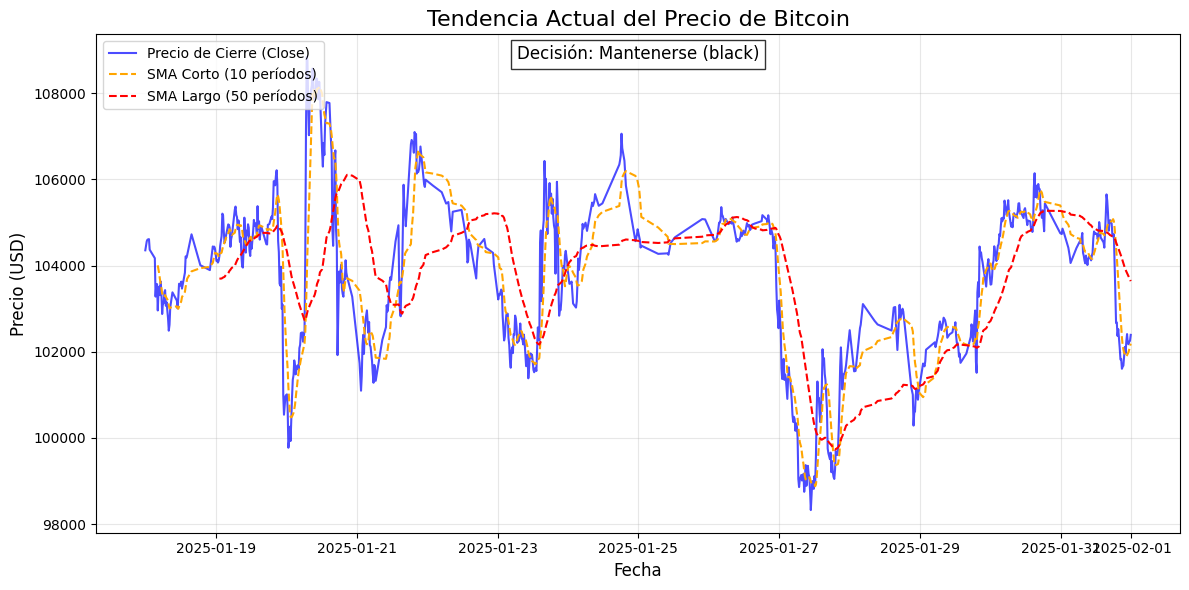

In [56]:
graficar_senal_actual()

# 6. Ciclo

[*********************100%***********************]  1 of 1 completed

Iniciando ciclo de análisis...


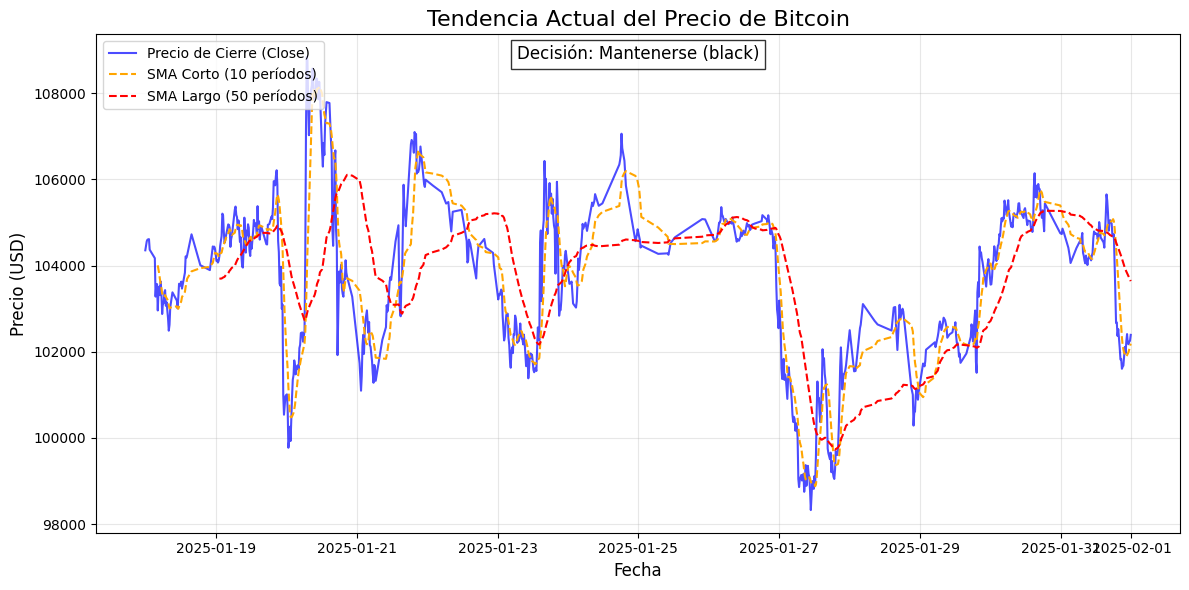

Esperando 5 minutos antes de la siguiente decisión...


KeyboardInterrupt: 

In [57]:
while True:
    print("Iniciando ciclo de análisis...")

    # Paso 1: Descargar los datos y extraer el precio actual
    importar_base_bitcoin()
    extraer_tendencias()

    # Paso 2: Limpiar los datos y calcular las medias móviles
    limpieza_datos()
    calcular_sma()

    # Paso 3: Tomar la decisión de compra/venta
    tomar_decisiones()

    # Paso 4: Graficar las tendencias y señales

    graficar_senal_actual()

    # Esperar 5 minutos antes de la siguiente decisión
    print("Esperando 5 minutos antes de la siguiente decisión...")
    time.sleep(300)